# Time Series Modeling using Python
<div class="alert alert-info"><strong>Part I : Statistical analysis of financial market data</strong></div>

#### Notebook Created on: 20 June 2020
##### Last Update: 4 Jul 2020
##### Version 1.0
##### Author: Vivek Krishnamoorthy

## **Agenda for today**
- Time series modeling - A preview before the lectures
- Introduction
- Commonly used terminology
- Transforming prices to returns
- Visualizing the data
- Calculating realized volatility
- Detecting outliers
- Verifying the stylized facts of asset returns


### Introduction

Let's begin with a simple definition of time series.

> *Sequential observations of the same variable. The sequence we refer to is observed over time.*

For example: the daily closing prices of the `INFY` stock price over the last 500 trading days, annual CPI over the past 25 years, etc.

We use the following notations to represent it. 
$$\{x_1, x_2, \dots, x_T\}$$ or $$\{x_t\},\: t = 1, 2,\dots, T$$

You can see time series everywhere. Like medicine (recording the weight, sugar levels, blood pressure of a patient over time), climate studies (sea levels, temperatures observed daily for years), engineering, social sciences, etc.

As quant finance professionals, we deal with time-series data day in and day out. The most important question we ask and seek to answer is **"What will be the price (or volatility) the next day or week or month?"**.

We can use different prediction methods to answer it depending on the assets and markets traded, the length of the forecast period, the dataset used, the required quality of prediction, the capital invested, etc.

### Commonly used terminology

#### 1 Stationarity & Non-Stationarity

**A stationary process is one whose statistical properties (like mean, variance, covariance, etc.) remain constant in time.** However, most business and financial time series are **non-stationary** in their original forms ex. stock prices, market index levels.

Stationary processes are easier to deal with due to the constancy of their statistical properties. We can therefore simply forecast that their characteristics remain the same in the future as they were in the past.

So a critical step in our analysis is to transform a non-stationary process into a stationary one ([like we do further ahead](#convert)). We then make predictions and THEN just reverse the transformation to obtain predicted values of the actual series we started with. All of the painful details that I've mentioned above are usually taken care of by modern statistical software like Python, R, etc.
 
The images below from [Sean Abu](#seanabu) distinguish between stationary and non-stationary processes.

![alt text](Mean_nonstationary.png)

![alt text](Var_nonstationary.png "Title")


#### 2 ACF and PACF

In statistics, correlation measures the strength of the linear relationship between any two variables. Time series data have one peculiar feature: ***Persistence in successive observations***.

ACF and PACF are metrics that help us quantify this.

**Autocorrelation function (ACF):** We measure the correlation of a variable with a lagged version of itself. This is also called serial correlation.

**Partial Autocorrelation function (PACF):** The autocorrelation of a variable with a k-time period lagged version of itself is comprised of two effects: 
- the direct effect (i.e. the pure linear relationship between the variable and its k-period lagged version) and,
- the indirect effect (the linear relationship between the variable and its k-period lagged version that oozes through the shorter lags)). 

PACF gives us the correlation for **only the direct effect**.

I adapt and use some of the ideas and code here from [Eryk Lewinson](#eryk), the [ARCH documentation](#arch), and [other sources](#others) mentioned.

<a id = 'convert'></a>

### A simple technique to stationarize: Transforming prices to returns

Asset prices are usually non-stationary. We try to make it stationary by dealing with its returns instead. This can be either simple returns or log returns. For daily or intraday returns, the difference between simple returns and log returns is very small. As the time scale increases, this difference grows in size. Log returns are always lesser than the corresponding simple returns.

We now calculate both types of returns for `GLENMARK` prices.

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [3]:
end1 = datetime.date(2020, 6, 30)
start1 = datetime.date(2005, 7, 1)
ticker1 = "GLENMARK.NS"

In [4]:
df = yf.download(ticker1, start=start1, end=end1, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

Downloaded 3686 rows and 6 columns of GLENMARK.NS data


In [5]:
df1 = df.copy()

In [6]:
print(df1.head(3))
print(df1.tail(3))

              Open       High        Low      Close  Adj Close   Volume
Date                                                                   
2005-07-01  66.875  71.750000  66.875000  71.000000  67.803291  1596814
2005-07-04  71.000  72.974998  71.000000  72.762497  69.486420   999094
2005-07-05  73.125  74.974998  71.550003  72.474998  69.211868  1425164
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-06-25  450.000000  469.899994  434.000000  458.100006  455.808594   
2020-06-26  465.000000  477.750000  461.549988  466.700012  464.365570   
2020-06-29  474.899994  484.700012  465.100006  467.799988  465.460052   

              Volume  
Date                  
2020-06-25  17246798  
2020-06-26  11100642  
2020-06-29  14878704  


In [7]:
#############################################################################
###################### IGNORE THIS CELL #####################################
#############################################################################

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df1.to_csv("GLENMARK.NS.csv")
# df1 = pd.read_csv("GLENMARK.NS", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [8]:
df1.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df1.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df1.tail())

             adj_close
Date                  
2020-06-23  482.574005
2020-06-24  456.903076
2020-06-25  455.808594
2020-06-26  464.365570
2020-06-29  465.460052


In [9]:
df1['simple_returns'] = df1['adj_close'].pct_change()
df1['log_returns'] = np.log(df1['adj_close'] / df1['adj_close'].shift(1))

In [10]:
print(df1.head())
print(df1.tail())

            adj_close  simple_returns  log_returns
Date                                              
2005-07-01  67.803291             NaN          NaN
2005-07-04  69.486420        0.024824     0.024521
2005-07-05  69.211868       -0.003951    -0.003959
2005-07-06  69.975853        0.011038     0.010978
2005-07-07  68.817947       -0.016547    -0.016686
             adj_close  simple_returns  log_returns
Date                                               
2020-06-23  482.574005       -0.066859    -0.069199
2020-06-24  456.903076       -0.053196    -0.054663
2020-06-25  455.808594       -0.002395    -0.002398
2020-06-26  464.365570        0.018773     0.018599
2020-06-29  465.460052        0.002357     0.002354


### Visualizing the data

Because time series is sequential, plotting the data allows us to get an intuitive feel for how it fluctuates over time. It also helps us reason about features that could explain the variation we see.

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Log returns (%)')]

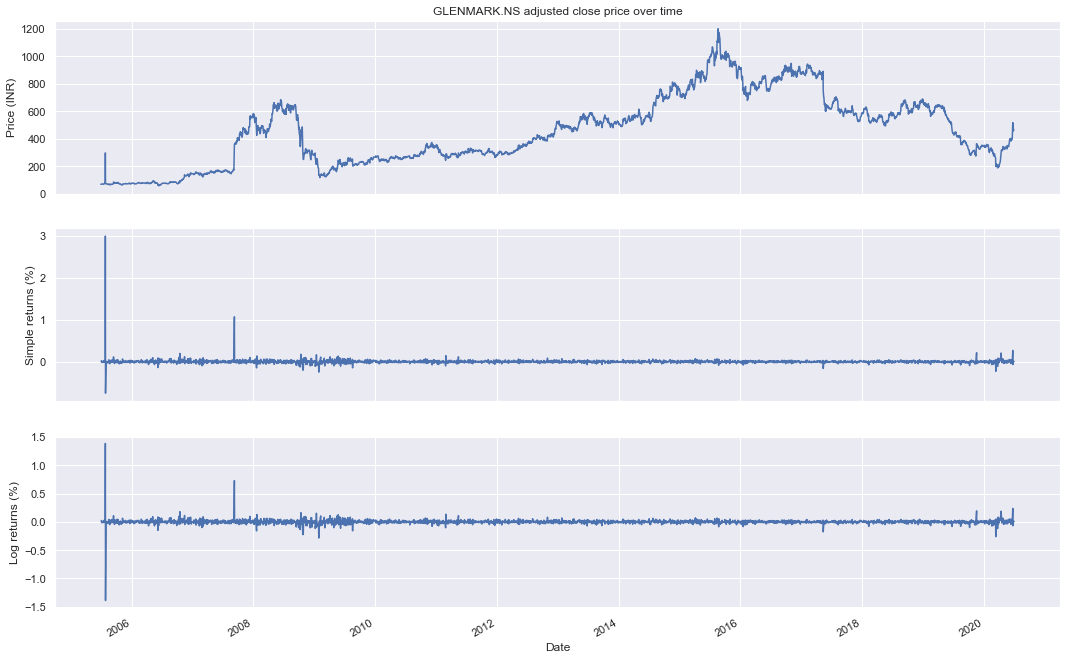

In [38]:
## Using the pandas .plot() routine
M = 3
N = 1
fig, ax = plt.subplots(M, N, figsize=(18, 12), sharex=True)
df1['adj_close'].plot(ax=ax[0])
ax[0].set(title=f"{ticker1} adjusted close price over time", 
          ylabel="Price (INR)")
# ax[0].grid()
df1['simple_returns'].plot(ax=ax[1])
ax[1].set(ylabel="Simple returns (%)")
# ax[1].grid()
df1['log_returns'].plot(ax=ax[2])
ax[2].set(xlabel="Date", 
          ylabel="Log returns (%)")
# ax[2].grid()

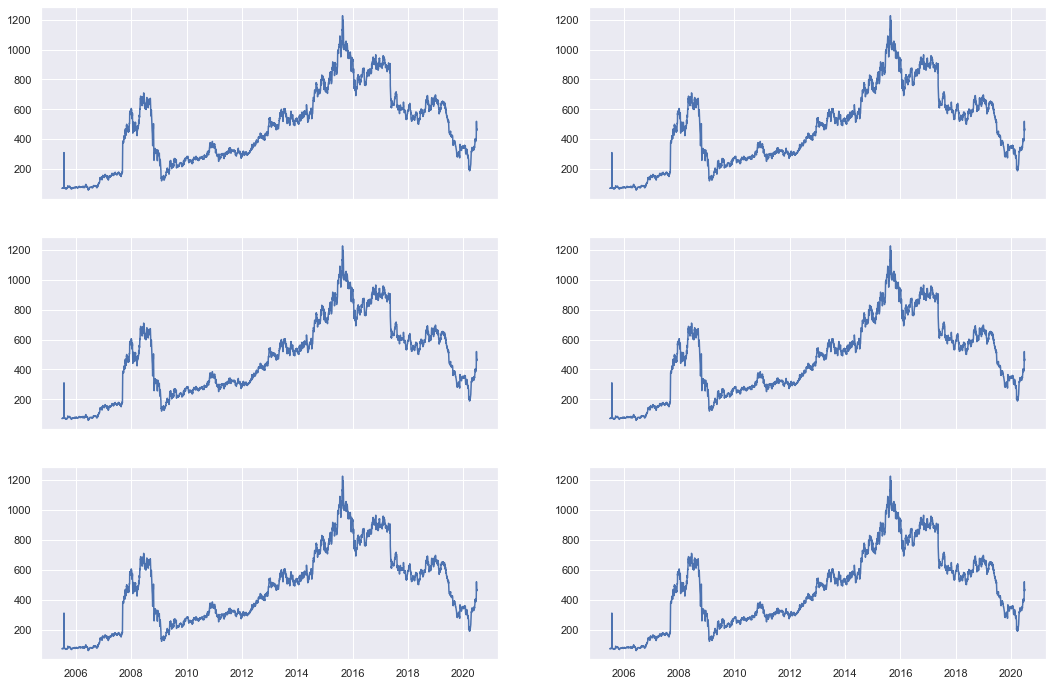

In [37]:
## Using the pandas .plot() routine
M = 3
N = 2
fig, ax = plt.subplots(M, N, figsize=(18, 12), sharex=True)
# df1['adj_close'].plot(ax=ax[0])
# ax[0].set(title=f"{ticker1} adjusted close price over time", 
#           ylabel="Price (INR)")
# # ax[0].grid()
# df1['simple_returns'].plot(ax=ax[1])
# ax[1].set(ylabel="Simple returns (%)")
# # ax[1].grid()
# df1['log_returns'].plot(ax=ax[2])
# ax[2].set(xlabel="Date", 
#           ylabel="Log returns (%)")
# ax[2].grid()

ax[0,0].plot(df.Close)
ax[1,0].plot(df.Close)
ax[2,0].plot(df.Close)
ax[0,1].plot(df.Close)
ax[1,1].plot(df.Close)
ax[2,1].plot(df.Close)
# ax[1,0].set(title='shit',xlabel ='crazy', ylabel ='shit')
# ax[2,0].set(title='shit',xlabel ='crazy', ylabel ='shit')
# ax[0,1].set(title='shit',xlabel ='crazy', ylabel ='shit')
# ax[0,2].set(title='shit',xlabel ='crazy', ylabel ='shit')

Points to note:
- Similarity in the shapes of the simple returns and log returns. There is a difference in scale as we see from the Y-axis.
- Compare both return values (from the `pandas DataFrame`). What do you see?
- Plotting the price and the returns side by side allows us to observe the relationship between price and volatility in returns.

In [12]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## Trials with cufflinks and plotly
## ***********************************************************

## Using cufflinks and plotly

# import cufflinks as cf
# from plotly.offline import iplot, init_notebook_mode

# ## Config setup
# cf.set_config_file(world_readable=True, theme='polar',
#                    offline=True)

# init_notebook_mode()

## I needed to separately install chart_studio since iplot() is not displaying the chart
## Run the following on the Anaconda prompt or terminal
## pip install chart_studio
## conda install -c conda-forge nodejs
## conda update nodejs
## jupyterlab extension list
## conda install -c conda-forge jupyterlab-plotly-extension
# https://plotly.com/python/getting-started/#jupyterlab-support-python-35
# jupyter labextension install jupyterlab-plotly@4.8.2
# jupyter labextension list
# Still not working properly.

# df1.iplot(subplots=True, shape=(3, 1), shared_xaxes=True, 
#           title='GLENMARK adjusted close prices over time')

### Calculating realized volatility

Realized volatility calculates the magnitude of price movements of an asset over a specified time period. It's a commonly used risk measure.

We will now use the daily data to calculate monthly realized volatility (applying the [Barndorff-Nielsen & Shephard method](#bnshephard)) shown below.

1. Calculate the daily log returns
$$r_t = log (P_t) - log (P_{t-1}$$

2. Calculate the monthly realized variance by summing the squared returns for the `N` trading days of that month.
$$ \sum_{t=1}^N {r_t}^2$$

3. The monthly realized volatility is the square root of the above expression,

4. We annualize the value by multiplying the monthly realized volatility by $\sqrt{12}$.

Let's implement it in Python.

In [40]:
## Defining a function to calculate realized volatility

def realized_vol(x):
    return np.sqrt(np.sum(x ** 2))

In [41]:
## Calculating the monthly realized volatility

df1_real_vol = df1.groupby(pd.Grouper(freq='M'))[['log_returns']].apply(realized_vol)
# .apply would apply the function 'realized_vol' to the column selected (which would be 
# log returns for each month).
# Note that the function calculates the square root of the sum of squared returns for each month

In [42]:
df1_real_vol.rename(columns={'log_returns': 'realized_vol'}, inplace=True)

In [43]:
df1_real_vol.head()

,realized_vol
Date,
2005-07-31,1.964255
2005-08-31,0.103589
2005-09-30,0.156556
2005-10-31,0.110336
2005-11-30,0.098358


In [44]:
df1_real_vol.tail()

,realized_vol
Date,
2020-02-29,0.141583
2020-03-31,0.333845
2020-04-30,0.241255
2020-05-31,0.092689
2020-06-30,0.274420


In [45]:
## Calculating the annualized volatility

df1_real_vol['realized_vol'] = df1_real_vol['realized_vol'] * np.sqrt(12)

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Monthly realized volatility (%)')]

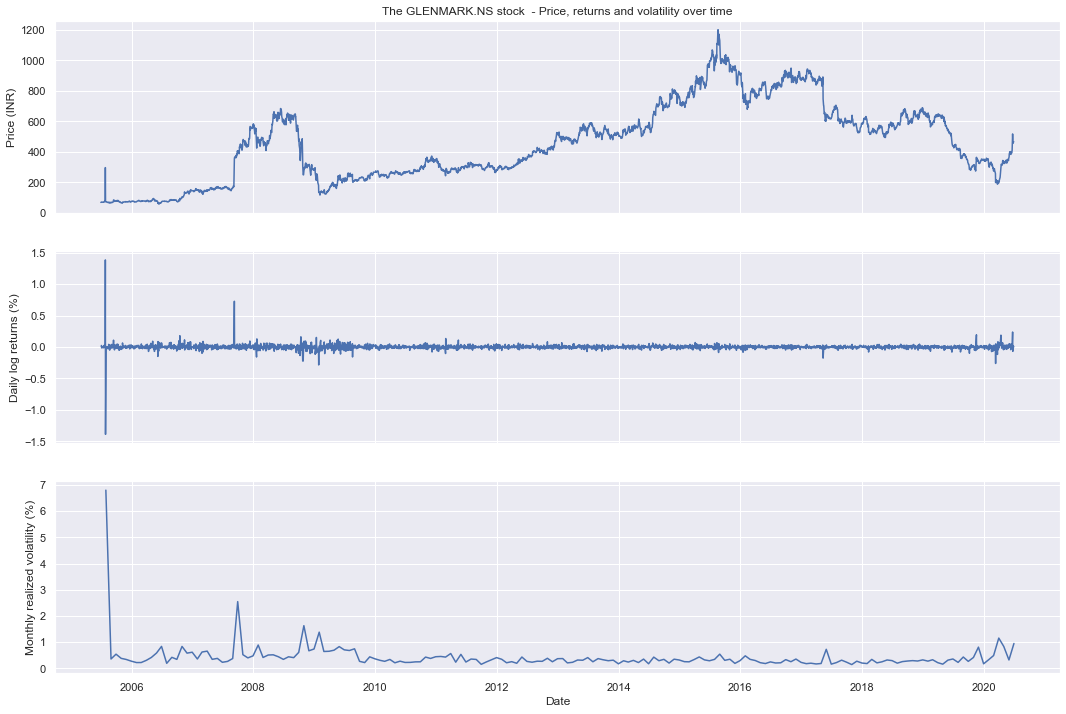

In [49]:
## Plotting the results together

M = 3
N = 1
fig, ax = plt.subplots(M, N, figsize=(18, 12), sharex=True)

ax[0].plot(df1['adj_close'])
ax[1].plot(df1['log_returns'])
ax[2].plot(df1_real_vol['realized_vol'])

ax[0].set(title=f"The {ticker1} stock  - Price, returns and volatility over time", 
          ylabel="Price (INR)")

ax[1].set(ylabel="Daily log returns (%)")
ax[2].set(xlabel="Date", 
          ylabel="Monthly realized volatility (%)")

Points to note:
- Extreme price changes are synonymous with large changes in daily returns.
- Large changes in returns often coincide with spikes in volatility
- There are some outliers in returns which can bias our interpretations
- We use the `.resample()` method in `pandas` when we want to change the frequency of our observations (ex. moving from daily returns to weekly returns or monthly returns). However, since realized volatility calculation is a little convoluted, we created the function `realized_vol`.

### Detecting outliers

Compared to many other fields in the social sciences, financial market data for the most part is quite clean (with relatively fewer errors). Nevertheless, it still behooves us to analyze our data and identify any observations that are significantly different from their neighboring observations. We call such data points, **outliers**.

Outliers could be because of:
- Incorrectly entered or calculated in the data source
- Missing data 
- Missing data auto-filled with random values
- A major market event, etc.

Outliers in our data affect both, the analysis we do and the results that follow when building a model or backtesting a strategy. No matter how good our trading strategy looks or how sophisticated our model is, remember: *'garbage in, garbage out'*.

Let's look at one way of catching and marking out the outliers in the `GLENMARK` data. We define outliers as any return value that is more than three standard deviations away from the mean.



In [51]:
window_length = 22

In [73]:
## Calculating the one month rolling mean and standard deviation

df1_rolling_stats = df1['simple_returns'].rolling(window
                                                  =window_length).agg([np.mean,
                                                                       np.std], axis='rows')

In [53]:
df1_rolling_stats.tail()

,mean,std
Date,,
2020-06-23,0.016589,0.062938
2020-06-24,0.013931,0.064650
2020-06-25,0.014313,0.064521
2020-06-26,0.015062,0.064471
2020-06-29,0.015924,0.064153


0.0016097848025875459

In [56]:
## Joining the newly created data to the original data

df1_all = df1.join(df1_rolling_stats)

In [63]:
df1_all.tail()

,adj_close,simple_returns,log_returns,mean,std,outlier
Date,,,,,,
2020-06-23,482.574005,-0.066859,-0.069199,0.016589,0.062938,0
2020-06-24,456.903076,-0.053196,-0.054663,0.013931,0.064650,0
2020-06-25,455.808594,-0.002395,-0.002398,0.014313,0.064521,0
2020-06-26,464.365570,0.018773,0.018599,0.015062,0.064471,0
2020-06-29,465.460052,0.002357,0.002354,0.015924,0.064153,0


In [58]:
## Defining a function to catch outliers

def catch_outliers(row, n_sigmas=3):
    x = row['simple_returns']
    μ = row['mean']
    σ = row['std']
    
    if (x > μ + 3 * σ) | (x < μ - 3 * σ):
        return 1
    else:
        return 0

In [67]:
## Catch the outliers

df1_all['outlier'] = df1_all.apply(catch_outliers, axis=1)

In [64]:
## Extract their values

outliers = df1_all.loc[df1_all['outlier'] == 1, ['simple_returns']]

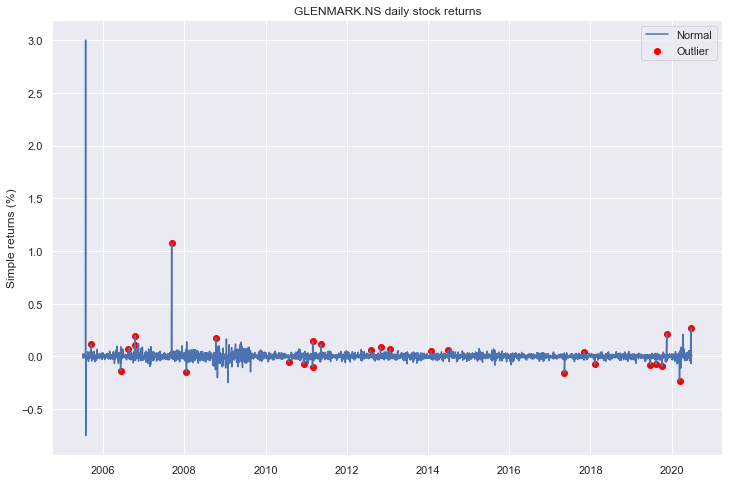

In [65]:
## Plotting the results together

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df1_all.index, df1_all['simple_returns'], 
        label="Normal")
ax.scatter(outliers.index, outliers['simple_returns'], color='red',
           label="Outlier")
ax.set(title=f"{ticker1} daily stock returns", 
          ylabel="Simple returns (%)")
ax.legend(loc="best")

Points to note:
- Outliers are marked with red dots. However, note that when there are multiple large returns (in magnitude) occurring in the same period, only the first gets identified and marked.
- This is due to the increase in the the values of the rolling statistics when multiple adjacent outliers enter the window.
- We can vary the window length based on the underlying data frequency. Here, the moving averages calculated would give monthly means and standard deviations of returns.
- We can also use exponential moving averages (EMA) instead of simple moving averages if we want the rolling statistics to react faster to recent price changes.
- Here, we have only identified and tagged them. The next important step is how to deal with them (which is outside the scope of this session). I leave you to explore this topic as a self-study exercise. 

### Stylized facts of asset returns

[Cont (2001)](#cont2001) does a detailed review of the empirical features of asset prices in financial markets. He presents common statistical properties (***stylized facts***) that financial asset returns share across markets, instruments and time periods.

We should be cognizant of them when we develop models to explain and forecast asset prices. 
We now work with 40 years of S&P daily data to examine some of their characteristics.

In [77]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as st
st.adfuller()

In [30]:
end2 = datetime.date(2019, 12, 31)
start2 = datetime.date(1980, 1, 1)
ticker2 = "^GSPC"

In [31]:
df = yf.download(ticker2, start=start2, end=end2, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker2} data")

Downloaded 10087 rows and 6 columns of ^GSPC data


In [32]:
df2 = df.copy()

In [33]:
#############################################################################
###################### IGNORE THIS CELL #####################################
#############################################################################

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df2.to_csv("GLENMARK.NS.csv")
# df2 = pd.read_csv("GLENMARK.NS", index_col=0, parse_dates=True)
# df2 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [34]:
print(df2.head())
print(df2.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1979-12-31  107.839996  108.529999  107.260002  107.940002  107.940002   
1980-01-02  107.940002  108.430000  105.290001  105.760002  105.760002   
1980-01-03  105.760002  106.080002  103.260002  105.220001  105.220001   
1980-01-04  105.220001  107.080002  105.089996  106.519997  106.519997   
1980-01-07  106.519997  107.800003  105.800003  106.809998  106.809998   

              Volume  
Date                  
1979-12-31  31530000  
1980-01-02  40610000  
1980-01-03  50480000  
1980-01-04  39130000  
1980-01-07  44500000  
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-12-23  3226.050049  3227.780029  3222.300049  3224.010010  3224.010010   
2019-12-24  3225.449951  3226.429932  3220.510010  3223.379883  3223.379883   
2019

In [35]:
df2.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df2.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df2.tail())

              adj_close
Date                   
2019-12-23  3224.010010
2019-12-24  3223.379883
2019-12-26  3239.909912
2019-12-27  3240.020020
2019-12-30  3221.290039


In [36]:
df2['log_returns'] = np.log(df2['adj_close'] / df2['adj_close'].shift(1))

#### 1. Non-normal distribution of returns

A standard assumption in finance models (like the CAPM, the Black-Scholes option pricing model) is that returns are normally distributed.

Numerous studies have however shown empirically that this is not quite true.
Specifically,
- *Left skewed* : Gains and loss distributions are not symmetrical. 
    - We see longer left tails compared to the right tails
    - The large negative returns are higher in magnitude compared to the large positive returns. 
 
- *Excess kurtosis* : The distribution is fat at the tails and higher than normal peaks
    - Large (and small) returns occur more frequently than the distributional assumption of normality expects.



In [37]:
df2.head()

,adj_close,log_returns
Date,,
1979-12-31,107.940002,NaN
1980-01-02,105.760002,-0.020403
1980-01-03,105.220001,-0.005119
1980-01-04,106.519997,0.012279
1980-01-07,106.809998,0.002719


In [38]:
df2.dropna(axis='rows', how='any', inplace=True)

In [39]:
## Generating a normal distribution curve with mean, variance, and range obtained from S&P 500 returns data

log_returns_range = np.linspace(min(df2['log_returns']), max(df2['log_returns']), num=1000)
μ = df2['log_returns'].mean()
σ = df2['log_returns'].std()
norm_pdf = scs.norm.pdf(log_returns_range, loc=μ, scale=σ)

Text(0.5, 1.0, 'Q-Q plot')

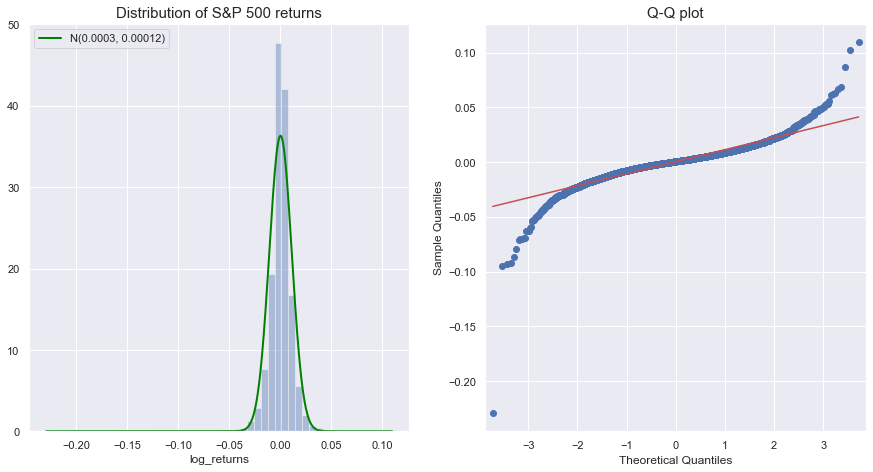

In [40]:
M = 1
N = 2

fig, ax = plt.subplots(M, N, figsize=(15, 7.5))

## histogram

sns.distplot(df2['log_returns'], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[0].plot(log_returns_range, norm_pdf, color='green', 
           linewidth=2, label=f"N({μ:.4f}, {σ**2:.5f})")
ax[0].legend(loc="best")

## Q-Q plot

qq_plot = sm.qqplot(df2['log_returns'], line='s', ax=ax[1])
## 's' is for standardized line to compare the plot with a normal distribution
ax[1].set_title("Q-Q plot", fontsize=15)

Points to note: *Distribution of S&P 500 returns*
- There is a visible difference in the shape of the returns histogram and the Gaussian (normal) distribution curve.
- The peak is higher in the histogram than the normal curve.
- The left tail of the distribution is longer.

Points to note: *Q-Q plot*

- Q-Q plots are used to compare empirical data to theoretical distributions. They are helpful in finding deviations at the tails.
- Here, we compare the distribution of the observed returns to a normal distribution.
- If we find that the dots are more or less on the red line, then it means that the data (in this case returns) is normally distributed.
- There is drift at both ends of the tails. This means that we have fatter tails violating the normality assumption.
- The size of the drift is higher on the left side of the plot than on the right side. This means that we observe large drops in returns but not equally large growths in returns.


In [41]:
## Running the Jarque-Bera test to check for normality of the sample data
## If the test statistic is very large and the p-value is less than 5%, we infer that the data is not
## normally distributed.

## For more details, check https://en.wikipedia.org/wiki/Jarque-Bera_test

from statsmodels.stats.stattools import jarque_bera
jb_test_stat, pvalue, _, _ = jarque_bera(df2['log_returns'])

In [42]:
## Printing the summmary statistics of the S&P 500 returns data

print('------------------- Summary Statistics --------------------')
print(f'Range of dates: {min(df2.index.date)} to {max(df2.index.date)}')
print(f'Number of observations: {df2.shape[0]}')
print(f"Mean: {df2['log_returns'].mean():.4f}")
print(f"Median: {df2['log_returns'].median():.4f}")
print(f"Min: {df2['log_returns'].min():.4f}")
print(f"Max: {df2['log_returns'].max():.4f}")
print(f"Standard Deviation: {df2['log_returns'].std():.4f}")
print(f"Skewness: {df2['log_returns'].skew():.4f}")
print(f"Kurtosis: {df2['log_returns'].kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")
print('------------------------------------------------------------')

------------------- Summary Statistics --------------------
Range of dates: 1980-01-02 to 2019-12-30
Number of observations: 10086
Mean: 0.0003
Median: 0.0005
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0110
Skewness: -1.1471
Kurtosis: 26.5549
Jarque-Bera statistic: 298247.89 with p-value: 0.00
------------------------------------------------------------


Points to note:
- The mean is less than the median. Seen in negatively skewed distributions.
- Confirmed by the coefficient of skewness (which is negative).
- Excess kurtosis seen (anything above 0 is deemed as excess kurtosis. Normal distribution has a kurtosis of 0 when measured using the pandas kurtosis method) .
- The p-value of the Jarque-Bera test shows non-normality of the data.

#### 2. Volatility Clustering

> *When it rains, it pours*.

We observe from historical data that the volatility of the returns appears to change over time. Relatively tranquil periods in the market persist for a while. Similarly market turbulence like in 2008 and 2009 also cluster together.

In [43]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## ***********************************************************


# Simulating normally distributed returns for GLENMARK and S&P 500
sample1 = pd.DataFrame(np.random.normal(loc=df1['log_returns'].mean(), 
                                     scale=df1['log_returns'].std(), 
                                     size=df1['log_returns'].shape[0]), 
                    index = df1.index)

sample2 = pd.Series(np.random.normal(loc=df2['log_returns'].mean(), 
                                     scale=df2['log_returns'].std(), 
                                     size=df2['log_returns'].shape[0]), 
                    index = df2.index)


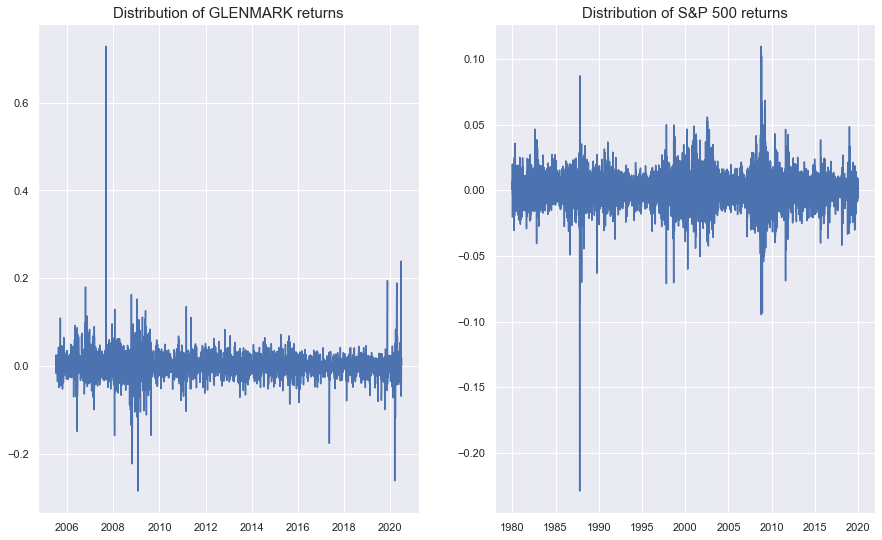

In [44]:
## Plotting the daily returns of GLENMARK and S&P 500 side by side 

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

ax[0].set_title("Distribution of GLENMARK returns", fontsize=15)
ax[0].plot(df1['log_returns'])

ax[1].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[1].plot(df2['log_returns'])

Points to note:
- For Glenmark, between 2008 and 2010, there's a higher swing of positive and negative returns. Notice how it's quite different from between 2016 and 2018.
- Similar waves of high and low volatility periods seen in S&P returns

#### 3. Absence of autocorrelations

Autocorrelation measures the degree of similarity between a time series process and a lagged version of itself. We measure it at different lags to unearth any patterns that repeat consistently.

Studies have shown that there is little autocorrelation observed in asset returns except for short time scales (of the order of 15 to 20 minutes).


In [45]:
n_lags = 50
significance_level = 0.05

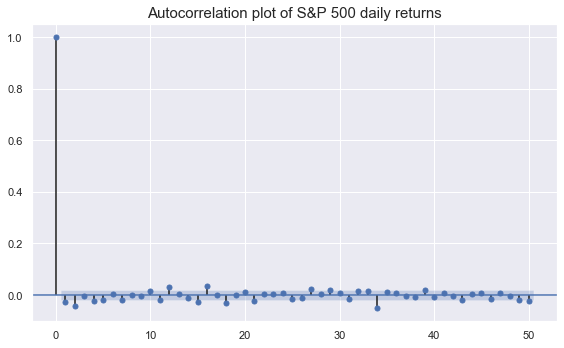

In [46]:
M = 8
N = 5

fig, ax = plt.subplots(figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'], lags=n_lags, 
                                 alpha=significance_level, ax=ax)
ax.set_title("Autocorrelation plot of S&P 500 daily returns", fontsize=15)
plt.tight_layout()
plt.show()

Points to note:
- We do not look at autocorrelation at lag 0.
- A few values that lie outside the blue confidence interval are statistically significant
- Visually, it appears that there is very little autocorrelation in the returns


#### 4. Slow decay of autocorrelations in absolute and squared returns

We follow the same procedure as above but this time we run it on absolute returns and squared returns. We can then plot the autocorrelation function (ACF) at different lags.

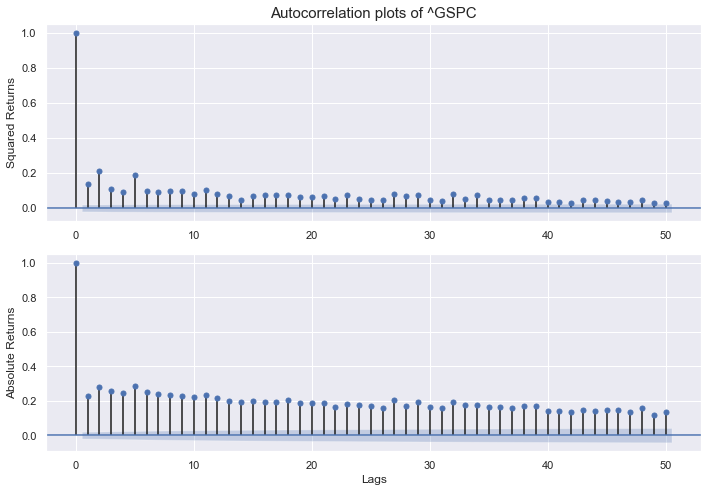

In [178]:
M, N = 10, 7
fig, ax = plt.subplots(2, 1, figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'] ** 2, lags=n_lags, 
                      alpha=significance_level, ax=ax[0])
ax[0].set_title(f"Autocorrelation plots of {ticker2}", fontsize=15)
ax[0].set(ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df2['log_returns']), lags=n_lags, 
                      alpha=significance_level, ax=ax[1])
ax[1].set(title="", xlabel='Lags', ylabel="Absolute Returns")

plt.tight_layout()
plt.show()

Points to note:
- There is is a slow and uneven decay of the ACF plot.
- The ACF of the squared returns decrease faster than that of the absolute returns.
- There is significant autocorrelation as seen in the literature.

#### 5. Leverage effect

There is a negative correlation between the volatility (most measures) of an asset and its returns. i.e. When prices go up, there is less volatility in the asset returns and vice-versa.

We verify it using two different methods. 

- In the first one, we measure volatility as the standard deviation of the asset returns. 
- In the second one, we will use the VIX index (often called the *fear index* of Wall Street), a popular market metric that tracks expectations of volatility.


In [179]:
df1['ma_std_252'] = df1['log_returns'].rolling(window=252).std()
df1['ma_std_21'] = df1['log_returns'].rolling(window=21).std()

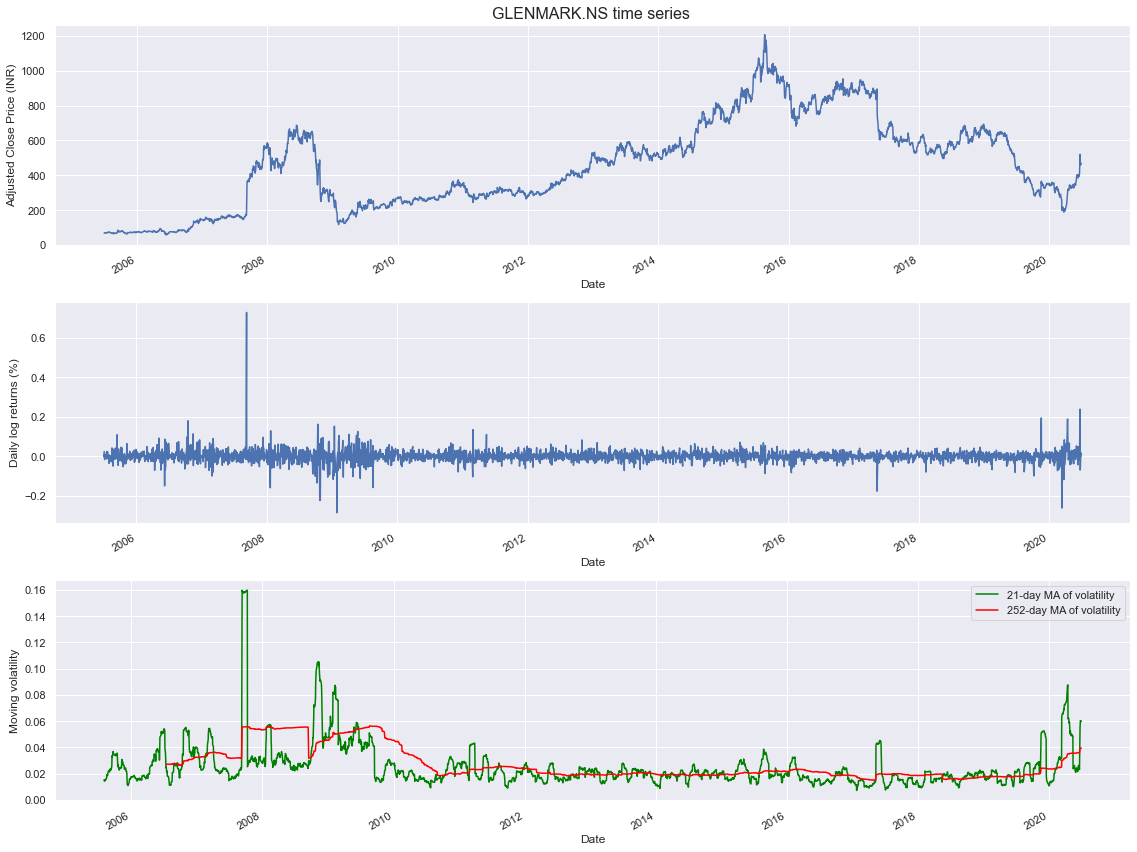

In [180]:
## Method I

M, N = 16, 12
fig, ax = plt.subplots(3, 1, figsize=(M, N))

df1['adj_close'].plot(ax=ax[0])
ax[0].set_title(f"{ticker1} time series ", fontsize=16)
ax[0].set(ylabel="Adjusted Close Price (INR)")


df1['log_returns'].plot(ax=ax[1])
ax[1].set(ylabel="Daily log returns (%)")

df1['ma_std_21'].plot(ax=ax[2], color='green', label="21-day MA of volatility")
df1['ma_std_252'].plot(ax=ax[2], color='red', label="252-day MA of volatility")
ax[2].set(xlabel="Date", ylabel="Moving volatility")
ax[2].legend()

plt.tight_layout()

Points to note:
- Leverage effect is visible. There seems to be a pattern of prices going up and volatility being low in those phases and vice-versa.

In [182]:
## Method II

start3 = start2
end3 = end2
ticker3 = "^VIX"

df = yf.download([ticker2, ticker3], start=start3, end=end3, progress=False)

In [183]:
df.shape

(10087, 12)

In [184]:
df.tail()

Adj Close               Close                High         \
                  ^GSPC   ^VIX        ^GSPC   ^VIX        ^GSPC   ^VIX   
Date                                                                     
2019-12-23  3224.010010  12.61  3224.010010  12.61  3227.780029  12.90   
2019-12-24  3223.379883  12.67  3223.379883  12.67  3226.429932  12.84   
2019-12-26  3239.909912  12.65  3239.909912  12.65  3240.080078  12.75   
2019-12-27  3240.020020  13.43  3240.020020  13.43  3247.929932  13.72   
2019-12-30  3221.290039  14.82  3221.290039  14.82  3240.919922  15.14   

                    Low                Open             Volume       
                  ^GSPC   ^VIX        ^GSPC   ^VIX       ^GSPC ^VIX  
Date                                                                 
2019-12-23  3222.300049  12.41  3226.050049  12.81  3060610000  0.0  
2019-12-24  3220.510010  12.56  3225.449951  12.65  1296540000  0.0  
2019-12-26  3227.199951  11.72  3227.199951  12.74  2160680000  0.0  
2019-12-27  3234.370117  11.89  3247.229980  12.61  2428670000  0.0  
2019-12-30  3216.570068  13.44  3240.090088  13.74  3013290000  0.0

In [185]:
df.head()

Adj Close            Close             High              Low  \
                 ^GSPC ^VIX       ^GSPC ^VIX       ^GSPC ^VIX       ^GSPC   
Date                                                                        
1979-12-31  107.940002  NaN  107.940002  NaN  108.529999  NaN  107.260002   
1980-01-02  105.760002  NaN  105.760002  NaN  108.430000  NaN  105.290001   
1980-01-03  105.220001  NaN  105.220001  NaN  106.080002  NaN  103.260002   
1980-01-04  106.519997  NaN  106.519997  NaN  107.080002  NaN  105.089996   
1980-01-07  106.809998  NaN  106.809998  NaN  107.800003  NaN  105.800003   

                       Open         Volume       
           ^VIX       ^GSPC ^VIX     ^GSPC ^VIX  
Date                                             
1979-12-31  NaN  107.839996  NaN  31530000  NaN  
1980-01-02  NaN  107.940002  NaN  40610000  NaN  
1980-01-03  NaN  105.760002  NaN  50480000  NaN  
1980-01-04  NaN  105.220001  NaN  39130000  NaN  
1980-01-07  NaN  106.519997  NaN  44500000  NaN

In [187]:
df3 = df.copy()

In [188]:
df3 = df3[['Adj Close']]

In [189]:
df3.columns = df3.columns.droplevel(0)

In [191]:
df3.rename(columns={"^GSPC": "sp500", "^VIX": "vix"}, inplace=True)

In [192]:
df3.tail()

,sp500,vix
Date,,
2019-12-23,3224.010010,12.61
2019-12-24,3223.379883,12.67
2019-12-26,3239.909912,12.65
2019-12-27,3240.020020,13.43
2019-12-30,3221.290039,14.82


In [193]:
df3["log_returns"] = np.log(df3['sp500'] / df3['sp500'].shift(1))
df3["vol_returns"] = np.log(df3['vix'] / df3['vix'].shift(1))

In [194]:
df3.dropna(how="any", axis="rows", inplace=True)

In [195]:
df3.head()

,sp500,vix,log_returns,vol_returns
Date,,,,
1990-01-03,358.760010,18.190001,-0.002589,0.053640
1990-01-04,355.670013,19.219999,-0.008650,0.055079
1990-01-05,352.200012,20.110001,-0.009804,0.045266
1990-01-08,353.790009,20.260000,0.004504,0.007431
1990-01-09,349.619995,22.200001,-0.011857,0.091444


In [196]:
corr_coeff = df3['log_returns'].corr(df3['vol_returns'])

[Text(0, 0.5, 'VIX log returns'),
 Text(0.5, 0, 'S&P 500 log returns'),
 Text(0.5, 1.0, 'S&P 500 vs. VIX (ρ = -0.710)')]

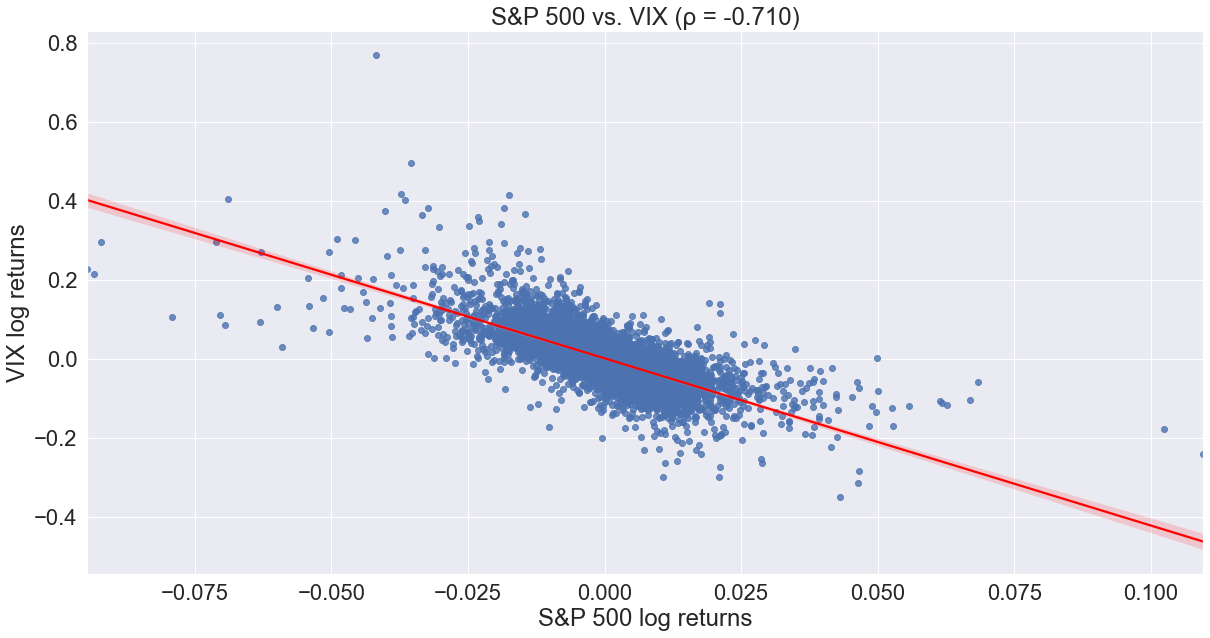

In [198]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
ax = sns.regplot(x='log_returns', y='vol_returns', data=df3, 
                 line_kws={'color':'red'})
ax.set(title=f"S&P 500 vs. VIX (ρ = {corr_coeff:.3f})", 
       xlabel="S&P 500 log returns", ylabel="VIX log returns")

Points to note:
- High negative value of correlation coefficient.
- Slope of the regression line which is also negative.

<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>

1. Barndorff‐Nielsen, O. E., & Shephard, N. (2002). Econometric analysis of realized volatility and its use in estimating stochastic volatility models. *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, 64(2), 253-280.
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R.(2001). Empirical properties of asset returns: stylized facts and statistical issues.
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons, 2005.
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Archie Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press, 1997.

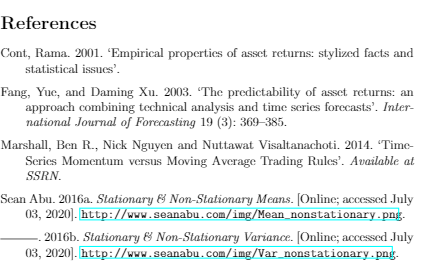